# Technical Analysis Of Intel

## Purpose
This phase of the project focuses on conducting an in-depth exploratory data analysis (EDA) of the selected stock. The goal is to extract valuable insights and explore key statistics that will lay the foundation for building a robust stock market forecasting system capable of providing actionable recommendations—Buy, Sell, or Hold.
### 1.0 Load Data and Calculate Key Statistics

## Potential stocks of interest 
    - INTC  
    - AAPL
    - INTC
    - MLTX
    - TSLA
    - HON


In [54]:
# Importing Libraries and Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import mplfinance as mpf
import plotly.graph_objects as go
import yfinance as yf
from scipy.stats import norm
from SimulateDay import add_columns
import datetime
stock_df = pd.read_csv('data/sp500_stocks.csv')

In [55]:

company_df = pd.read_csv('data/sp500_companies.csv')
stock_df = pd.read_csv('data/sp500_stocks.csv')

def _select_stock():
    company_name = input('Enter the name of the company: ')
    return stock_df[stock_df['Symbol'] == company_name]

stock_df = _select_stock()
stock_df

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
144885,2010-01-04,AAPL,6.572423,7.643214,7.660714,7.585000,7.622500,493729600.0
144886,2010-01-05,AAPL,6.583786,7.656429,7.699643,7.616071,7.664286,601904800.0
144887,2010-01-06,AAPL,6.479064,7.534643,7.686786,7.526786,7.656429,552160000.0
144888,2010-01-07,AAPL,6.467087,7.520714,7.571429,7.466071,7.562500,477131200.0
144889,2010-01-08,AAPL,6.510081,7.570714,7.571429,7.466429,7.510714,447610800.0
...,...,...,...,...,...,...,...,...
148595,2024-10-01,AAPL,226.210007,226.210007,229.649994,223.740005,229.520004,63285000.0
148596,2024-10-02,AAPL,226.779999,226.779999,227.369995,223.020004,225.889999,32880600.0
148597,2024-10-03,AAPL,225.669998,225.669998,226.809998,223.320007,225.139999,34044200.0
148598,2024-10-04,AAPL,226.800003,226.800003,228.000000,224.130005,227.899994,37245100.0


In [56]:
stock_df['1_Day_Return'] = (stock_df['Close'] - stock_df['Close'].shift(1)) / stock_df['Close'].shift(1) * 100
stock_df['5_Day_Return'] = (stock_df['Close'] - stock_df['Close'].shift(5)) / stock_df['Close'].shift(5) * 100
stock_df['10_Day_Return'] = (stock_df['Close'] - stock_df['Close'].shift(10)) / stock_df['Close'].shift(10) * 100
stock_df['20_Day_Return'] = (stock_df['Close'] - stock_df['Close'].shift(20)) / stock_df['Close'].shift(20) * 100
stock_df['50_Day_Return'] = (stock_df['Close'] - stock_df['Close'].shift(50)) / stock_df['Close'].shift(50) * 100
stock_df['200_Day_Return'] = (stock_df['Close'] - stock_df['Close'].shift(200)) / stock_df['Close'].shift(200) * 100

stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)
stock_df['Best_Return'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].max(axis=1)
stock_df['Best_Return_Window'] = stock_df['Best_Return_Window'].replace('_Day_Return', '', regex=True)


/var/folders/75/l95mxw1j5w9ddljb82_6_m_40000gn/T/ipykernel_72466/4008321228.py:8: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


In [57]:
# Create lag columns
stock_df['close_lag1'] = stock_df['Close'].shift(1)
stock_df['close_lag2'] = stock_df['Close'].shift(2)
stock_df['close_lag3'] = stock_df['Close'].shift(3)
stock_df['close_lag4'] = stock_df['Close'].shift(5)
stock_df['close_lag5'] = stock_df['Close'].shift(10)

stock_df['volume_lag1'] = stock_df['Volume'].shift(1)
stock_df['volume_lag2'] = stock_df['Volume'].shift(2)
stock_df['volume_lag3'] = stock_df['Volume'].shift(3)
stock_df['volume_lag4'] = stock_df['Volume'].shift(5)
stock_df['volume_lag5'] = stock_df['Volume'].shift(10)

In [58]:
# Create new columns with Moving Averages and Standard Deviations

stock_df['Date'] = pd.to_datetime(stock_df['Date'])

stock_df['MA_10'] = stock_df.groupby('Symbol')['Close'].rolling(window=10).mean().reset_index(level=0, drop=True)
stock_df['MA_20'] = stock_df.groupby('Symbol')['Close'].rolling(window=20).mean().reset_index(level=0, drop=True)
stock_df['MA_50'] = stock_df.groupby('Symbol')['Close'].rolling(window=50).mean().reset_index(level=0, drop=True)
stock_df['MA_200'] = stock_df.groupby('Symbol')['Close'].rolling(window=200).mean().reset_index(level=0, drop=True)
stock_df['std_10'] = stock_df.groupby('Symbol')['Close'].rolling(window=10).std().reset_index(level=0, drop=True)
stock_df['std_20'] = stock_df.groupby('Symbol')['Close'].rolling(window=20).std().reset_index(level=0, drop=True)
stock_df['std_50'] = stock_df.groupby('Symbol')['Close'].rolling(window=50).std().reset_index(level=0, drop=True)
stock_df['std_200'] = stock_df.groupby('Symbol')['Close'].rolling(window=200).std().reset_index(level=0, drop=True)


In [59]:
# Create new columns with Bollinger Bands for each Moving Average

stock_df['upper_band_10'] = stock_df['MA_10'] + (stock_df['std_10'] * 2)
stock_df['lower_band_10'] = stock_df['MA_10'] - (stock_df['std_10'] * 2)

stock_df['upper_band_20'] = stock_df['MA_20'] + (stock_df['std_20'] * 2)
stock_df['lower_band_20'] = stock_df['MA_20'] - (stock_df['std_20'] * 2)

stock_df['upper_band_50'] = stock_df['MA_50'] + (stock_df['std_50'] * 2)
stock_df['lower_band_50'] = stock_df['MA_50'] - (stock_df['std_50'] * 2)


stock_df['upper_band_200'] = stock_df['MA_200'] + (stock_df['std_200'] * 2)
stock_df['lower_band_200'] = stock_df['MA_200'] - (stock_df['std_200'] * 2)

In [60]:
# Create new columns Indicating Golden Cross and Death Cross

stock_df['Golden_Cross_Short'] = np.where((stock_df['MA_10'] > stock_df['MA_20']) & (stock_df['MA_10'].shift(1) <= stock_df['MA_20'].shift(1)), 1, 0)
stock_df['Golden_Cross_Medium'] = np.where((stock_df['MA_20'] > stock_df['MA_50']) & (stock_df['MA_20'].shift(1) <= stock_df['MA_50'].shift(1)), 1, 0)
stock_df['Golden_Cross_Long'] = np.where((stock_df['MA_50'] > stock_df['MA_200']) & (stock_df['MA_50'].shift(1) <= stock_df['MA_200'].shift(1)), 1, 0)

stock_df['Death_Cross_Short'] = np.where((stock_df['MA_10'] < stock_df['MA_20']) & (stock_df['MA_10'].shift(1) >= stock_df['MA_20'].shift(1)), 1, 0)
stock_df['Death_Cross_Medium'] = np.where((stock_df['MA_20'] < stock_df['MA_50']) & (stock_df['MA_20'].shift(1) >= stock_df['MA_50'].shift(1)), 1, 0)
stock_df['Death_Cross_Long'] = np.where((stock_df['MA_50'] < stock_df['MA_200']) & (stock_df['MA_50'].shift(1) >= stock_df['MA_200'].shift(1)), 1, 0)

In [61]:
# Create new columns with Rate of Change and Average Volume

stock_df['ROC'] = ((stock_df['Close'] - stock_df['Close'].shift(1)) / stock_df['Close'].shift(1)) * 100

stock_df['AVG_Volume_10'] = stock_df.groupby('Symbol')['Volume'].rolling(window=10).mean().reset_index(level=0, drop=True)
stock_df['AVG_Volume_20'] = stock_df.groupby('Symbol')['Volume'].rolling(window=20).mean().reset_index(level=0, drop=True)
stock_df['AVG_Volume_50'] = stock_df.groupby('Symbol')['Volume'].rolling(window=50).mean().reset_index(level=0, drop=True)
stock_df['AVG_Volume_200'] = stock_df.groupby('Symbol')['Volume'].rolling(window=200).mean().reset_index(level=0, drop=True)

In [62]:
# Create new columns signaling candlestick patterns 

def is_doji(row):
    return abs(row['Close'] - row['Open']) <= (row['High'] - row['Low']) * 0.1
def is_bullish_engulfing(current_row, previous_row):
    # Example logic for identifying a bullish engulfing pattern
    if previous_row['Close'] < previous_row['Open'] and current_row['Close'] > current_row['Open'] and current_row['Close'] > previous_row['Open'] and current_row['Open'] < previous_row['Close']:
        return True
    return False

def is_bearish_engulfing(current_row, previous_row):
    # Example logic for identifying a bearish engulfing pattern
    if previous_row['Close'] > previous_row['Open'] and current_row['Close'] < current_row['Open'] and current_row['Close'] < previous_row['Open'] and current_row['Open'] > previous_row['Close']:
        return True
    return False

# Doji Candlestick Pattern, identified by a small body and long wicks
stock_df['Doji'] = stock_df.apply(is_doji, axis=1)

# Bullish and Bearish Engulfing Candlestick Patterns, identified by a large body that engulfs the previous candle
stock_df['Bullish_Engulfing'] = stock_df.apply(lambda row: is_bullish_engulfing(row, stock_df.shift(1).loc[row.name]), axis=1)
stock_df['Bearish_Engulfing'] = stock_df.apply(lambda row: is_bearish_engulfing(row, stock_df.shift(1).loc[row.name]), axis=1)

In [63]:
# Create new columns for MACD, Signal Line and MACD Histogram

def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    # Calculate the short-term EMA
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    
    # Calculate the long-term EMA
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    
    # Calculate the MACD line
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    
    # Calculate the Signal line
    df['Signal'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    
    # Calculate the MACD histogram
    df['MACD_Hist'] = df['MACD'] - df['Signal']
    
    return df

stock_df = calculate_macd(stock_df)

In [64]:
# Create new columns for Average True Range (ATR) and True Range (TR)

stock_df['Previous_Close'] = stock_df['Close'].shift(1)

# True Range, Shows the volatility of the stock
stock_df['TR'] = stock_df.apply(
    lambda row: max(
        row['High'] - row['Low'],  # High - Low
        abs(row['High'] - row['Previous_Close']),  # |High - Previous Close|
        abs(row['Low'] - row['Previous_Close'])  # |Low - Previous Close|
    ), axis=1
)

# Average True Range, Shows the average volatility of the stock
stock_df['ATR'] = stock_df['TR'].rolling(window=10).mean()

In [65]:
# Create new columns for Relative Strength Index (RSI)

def calculate_rsi(df, window=10):
    # Calculate daily price changes
    delta = df['Close'].diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the average gain and average loss
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    # Calculate the Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Add RSI column to the DataFrame
stock_df['RSI_10_Day'] = calculate_rsi(stock_df)

In [66]:
# Create new columns for 10 Day Rate of Change (ROC)
stock_df['10_Day_ROC'] = ((stock_df['Close'] - stock_df['Close'].shift(10)) / stock_df['Close'].shift(10)) * 100

In [67]:
# Create new columns for 10,20,50 day resistance and support levels
stock_df['Resistance_10_Day'] = stock_df['Close'].rolling(window=10).max()
stock_df['Support_10_Day'] = stock_df['Close'].rolling(window=10).min()
stock_df['Resistance_20_Day'] = stock_df['Close'].rolling(window=20).max()
stock_df['Support_20_Day'] = stock_df['Close'].rolling(window=20).min()
stock_df['Resistance_50_Day'] = stock_df['Close'].rolling(window=50).max()
stock_df['Support_50_Day'] = stock_df['Close'].rolling(window=50).min()

In [68]:
# Create new columns for 10,20,50 day Volume Indicators
stock_df['Volume_MA_10'] = stock_df['Volume'].rolling(window=10).mean()
stock_df['Volume_MA_20'] = stock_df['Volume'].rolling(window=20).mean()
stock_df['Volume_MA_50'] = stock_df['Volume'].rolling(window=50).mean()

In [69]:
def create_OBV(df):
    df['OBV'] = 0
    for i in range(1, len(df)):
        if df['Close'].iloc[i] > df['Close'].iloc[i - 1]:
            df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1] + df['Volume'].iloc[i]
        elif df['Close'].iloc[i] < df['Close'].iloc[i - 1]:
            df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1] - df['Volume'].iloc[i]
        else:
            df.loc[df.index[i], 'OBV'] = df['OBV'].iloc[i - 1]
    return df

stock_df = create_OBV(stock_df)

In [70]:
def calculate_implied_volatility(option_price, stock_price, strike_price, time_to_expiry, risk_free_rate, sigma, option_type='call'):
    # Black-Scholes formula components
    d1 = (np.log(stock_price / strike_price) + (risk_free_rate + 0.5 * sigma ** 2) * time_to_expiry) / (sigma * np.sqrt(time_to_expiry))
    d2 = d1 - sigma * np.sqrt(time_to_expiry)
    
    if option_type == 'call':
        option_price_calc = stock_price * norm.cdf(d1) - strike_price * np.exp(-risk_free_rate * time_to_expiry) * norm.cdf(d2)
    else:
        option_price_calc = strike_price * np.exp(-risk_free_rate * time_to_expiry) * norm.cdf(-d2) - stock_price * norm.cdf(-d1)
    
    return option_price_calc

# Example: Fetch options data for a stock
ticker = 'INTC'
stock = yf.Ticker(ticker)
options = stock.option_chain('2024-10-18')

# Define a sigma value (e.g., 0.2 for 20% volatility)
sigma = 0.2

# Calculate implied volatility and delta for each option
for option in options.calls.itertuples():
    time_to_expiry = (pd.Timestamp('2024-12-20') - pd.Timestamp.today()).days / 365
    implied_volatility = calculate_implied_volatility(option.lastPrice, stock.history(period='1d')['Close'].iloc[-1], option.strike, time_to_expiry, 0.01, sigma)
    delta = norm.cdf((np.log(stock.history(period='1d')['Close'].iloc[-1] / option.strike) + (0.01 + 0.5 * implied_volatility ** 2) * time_to_expiry) / (implied_volatility * np.sqrt(time_to_expiry)))
    print(f"Strike: {option.strike}, Implied Volatility: {implied_volatility}, Delta: {delta}")

Strike: 10.0, Implied Volatility: 13.33970627920019, Delta: 0.9990505193238155
Strike: 11.0, Implied Volatility: 12.341676937637786, Delta: 0.9979999859586905
Strike: 12.0, Implied Volatility: 11.343647596075389, Delta: 0.9959914551108637
Strike: 13.0, Implied Volatility: 10.345618254517564, Delta: 0.992346998245317
Strike: 14.0, Implied Volatility: 9.34758891401553, Delta: 0.9860680819069687
Strike: 15.0, Implied Volatility: 8.34955966501639, Delta: 0.9757925703909309
Strike: 16.0, Implied Volatility: 7.351533920392729, Delta: 0.9598144798598331
Strike: 16.5, Implied Volatility: 6.852533469024621, Delta: 0.9490864212760404
Strike: 17.0, Implied Volatility: 6.353575544755653, Delta: 0.9362024513027618
Strike: 17.5, Implied Volatility: 5.854757017521326, Delta: 0.9209274098607729
Strike: 18.0, Implied Volatility: 5.356336445908632, Delta: 0.9030548355023889
Strike: 18.5, Implied Volatility: 4.858915549524905, Delta: 0.8824306448387801
Strike: 19.0, Implied Volatility: 4.363724980572869,

Implications for Options Trading:
Lower Strike Prices: Higher delta means these options are more likely to be exercised if the price moves favorably, and they provide higher leverage with a higher probability of profit.
Higher Strike Prices: Lower delta and implied volatility suggest these options have a very low chance of reaching the strike price and thus carry minimal value unless a significant price movement occurs.


### Preview Data with Additional Columns

In [71]:

stock_df['Z-score'] = (stock_df['Close'] - stock_df['Close'].mean()) / stock_df['Close'].std()
company_df.fillna(0, inplace=True)
stock_df.fillna(0, inplace=True)
stock_df


,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,1_Day_Return,5_Day_Return,...,Support_10_Day,Resistance_20_Day,Support_20_Day,Resistance_50_Day,Support_50_Day,Volume_MA_10,Volume_MA_20,Volume_MA_50,OBV,Z-score
144885,2010-01-04,AAPL,6.572423,7.643214,7.660714,7.585000,7.622500,493729600.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,0,-0.954569
144886,2010-01-05,AAPL,6.583786,7.656429,7.699643,7.616071,7.664286,601904800.0,0.172893,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,601904800,-0.954357
144887,2010-01-06,AAPL,6.479064,7.534643,7.686786,7.526786,7.656429,552160000.0,-1.590632,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,49744800,-0.956312
144888,2010-01-07,AAPL,6.467087,7.520714,7.571429,7.466071,7.562500,477131200.0,-0.184871,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,-427386400,-0.956536
144889,2010-01-08,AAPL,6.510081,7.570714,7.571429,7.466429,7.510714,447610800.0,0.664833,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.00,0.00,20224400,-0.955733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148595,2024-10-01,AAPL,226.210007,226.210007,229.649994,223.740005,229.520004,63285000.0,-2.914160,-0.510177,...,220.690002,233.0,216.320007,233.0,207.229996,77385650.0,62261735.00,54816292.00,16716479200,2.553796
148596,2024-10-02,AAPL,226.779999,226.779999,227.369995,223.020004,225.889999,32880600.0,0.251975,0.181121,...,226.210007,233.0,216.320007,233.0,207.229996,74684220.0,61713755.00,54674698.00,16749359800,2.562946
148597,2024-10-03,AAPL,225.669998,225.669998,226.809998,223.320007,225.139999,34044200.0,-0.489461,-0.813118,...,225.669998,233.0,216.320007,233.0,207.229996,71410510.0,61585195.00,54120030.00,16715315600,2.545128
148598,2024-10-04,AAPL,226.800003,226.800003,228.000000,224.130005,227.899994,37245100.0,0.500733,-0.434607,...,225.669998,233.0,216.320007,233.0,207.229996,43267030.0,61026300.00,53837108.00,16752560700,2.563267


In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Import Regression Models
from sklearn.linear_model import Lasso, Ridge, ElasticNet
# Define the features and target variable
features = ['Volume', 'MA_10', 'MA_20', 'MA_50', 'MA_200',
            'std_10', 'std_20', 'std_50', 'std_200', 'upper_band_10', 
            'lower_band_10', 'upper_band_20', 'lower_band_20', 'upper_band_50', 
            'lower_band_50', 'upper_band_200', 'lower_band_200', 'Golden_Cross_Short', 
            'Golden_Cross_Medium', 'Golden_Cross_Long', 'Death_Cross_Short',
            'Death_Cross_Medium', 'Death_Cross_Long', 'ROC', 'AVG_Volume_10', 
            'AVG_Volume_20', 'AVG_Volume_50', 'AVG_Volume_200', 'Doji', 'Bullish_Engulfing',
            'Bearish_Engulfing', 'MACD', 'Signal', 'MACD_Hist', 'TR', 'ATR', 'RSI_10_Day',
            '10_Day_ROC', 'Resistance_10_Day', 'Support_10_Day', 'Resistance_20_Day', 
            'Support_20_Day', 'Resistance_50_Day', 'Support_50_Day', 'Volume_MA_10', 
            'Volume_MA_20', 'Volume_MA_50', 'OBV', 'Z-score']
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
stock_df[features] = min_max_scaler.fit_transform(stock_df[features])
stock_df.columns


Index(['Date', 'Symbol', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
       '1_Day_Return', '5_Day_Return', '10_Day_Return', '20_Day_Return',
       '50_Day_Return', '200_Day_Return', 'Best_Return_Window', 'Best_Return',
       'close_lag1', 'close_lag2', 'close_lag3', 'close_lag4', 'close_lag5',
       'volume_lag1', 'volume_lag2', 'volume_lag3', 'volume_lag4',
       'volume_lag5', 'MA_10', 'MA_20', 'MA_50', 'MA_200', 'std_10', 'std_20',
       'std_50', 'std_200', 'upper_band_10', 'lower_band_10', 'upper_band_20',
       'lower_band_20', 'upper_band_50', 'lower_band_50', 'upper_band_200',
       'lower_band_200', 'Golden_Cross_Short', 'Golden_Cross_Medium',
       'Golden_Cross_Long', 'Death_Cross_Short', 'Death_Cross_Medium',
       'Death_Cross_Long', 'ROC', 'AVG_Volume_10', 'AVG_Volume_20',
       'AVG_Volume_50', 'AVG_Volume_200', 'Doji', 'Bullish_Engulfing',
       'Bearish_Engulfing', 'EMA_short', 'EMA_long', 'MACD', 'Signal',
       'MACD_Hist', 'Previous_Close', '

In [73]:
# Split the data into training and test sets
# Create action column as target
threshold = 2
# stock_df['Action'] = stock_df['Best_Return'].apply(lambda x: 'Buy' if x > threshold else ('Sell' if x < -threshold else 'Hold'))
# stock_df['Action'] = stock_df['Best_Return'].apply(lambda x: 0 if x > threshold else (1 if x < -threshold else 2))
def determine_action(row):
    # Buy conditions: Must meet multiple criteria for stronger Buy signal
    if row['Close'] != 0 and (((row['Close'] - row['close_lag1'])/(row['Close'])*100) > 1 ):
        return 2
    elif (row['Golden_Cross_Short'] == 1 or 
        row['MACD'] > row['Signal'] or 
        50 < row['RSI_10_Day'] < 70):
        return 0  # Buy
    # Sell conditions: Must meet multiple criteria for stronger Sell signal
    elif (row['Death_Cross_Short'] == 1 or 
          row['MACD'] < row['Signal'] or 
          row['RSI_10_Day'] > 80 and 
          row['Daily_Return'] < -0.01):
        return 1  # Sell
    else:
        return 2  # Hold


# Apply the function to create the 'Action' column
stock_df['Action'] = stock_df.apply(determine_action, axis=1)
stock_df['Action'].value_counts()



Action
0    2210
2     952
1     553
Name: count, dtype: int64

In [74]:
X = stock_df[features]
y = stock_df['Action']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [75]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [76]:
model = xgb.XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [77]:
# Evaluate the model 
import pprint   
class_report = classification_report(y_test, y_pred)
pprint.pprint(class_report)

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.99      1.00      0.99       451\n'
 '           1       0.98      0.97      0.98       103\n'
 '           2       1.00      0.99      1.00       189\n'
 '\n'
 '    accuracy                           0.99       743\n'
 '   macro avg       0.99      0.99      0.99       743\n'
 'weighted avg       0.99      0.99      0.99       743\n')


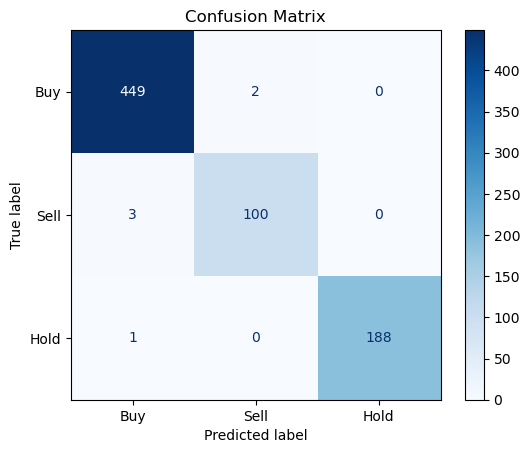

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
# cm = confusion_matrix(y_test, y_pred, labels=['Buy','Sell'])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Buy', 'Sell','Hold'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [81]:
import joblib
import os
last_day = X.iloc[3705].to_dict()

def predict_action(data):
    if type(model) == xgb.core.Booster:

        data_df = pd.DataFrame([data])

        # Select only the features used in training
        data_df = data_df[features]

        # Convert the DataFrame to DMatrix (required by XGBoost)
        dmatrix = xgb.DMatrix(data_df)

        # Predict using the loaded model
        prediction = model.predict(dmatrix)[0]
    else:
        data_df = pd.DataFrame([data])
        data_df = data_df[features]
        prediction = model.predict(data_df)[0]
    
    if prediction == 0:
        return 'Buy'
    elif prediction == 1:
        return 'Sell'
    else:
        return 'Hold'
        

def scale_data(data):
    features = ['Volume', 'MA_10', 'MA_20', 'MA_50', 'MA_200', 'std_10',
                'std_20', 'std_50', 'std_200', 'upper_band_10', 'lower_band_10', 
                'upper_band_20', 'lower_band_20', 'upper_band_50', 'lower_band_50', 
                'upper_band_200', 'lower_band_200', 'Golden_Cross_Short', 'Golden_Cross_Medium', 
                'Golden_Cross_Long', 'Death_Cross_Short', 'Death_Cross_Medium', 'Death_Cross_Long', 
                'ROC', 'AVG_Volume_10', 'AVG_Volume_20', 'AVG_Volume_50', 'AVG_Volume_200', 'Doji', 
                'Bullish_Engulfing', 'Bearish_Engulfing', 'MACD', 'Signal', 'MACD_Hist', 'TR', 'ATR', 
                'RSI_10_Day', '10_Day_ROC', 'Resistance_10_Day', 'Support_10_Day', 'Resistance_20_Day', 
                'Support_20_Day', 'Resistance_50_Day', 'Support_50_Day', 'Volume_MA_10', 'Volume_MA_20', 
                'Volume_MA_50', 'OBV', 'Z-score']
    min_max_scaler = MinMaxScaler()
    stock_df[features] = min_max_scaler.fit_transform(stock_df[features])
    return stock_df[features]
data = scale_data(stock_df)
last_day = data.iloc[3714].to_dict()
predict_action(last_day)

'Sell'

In [82]:
model0 = joblib.load('models/INTC_model.pkl')
if type(model0) == xgb.sklearn.XGBClassifier:
    print('XGBoost Model')
    print(type(model0)) 


XGBoost Model
<class 'xgboost.sklearn.XGBClassifier'>


In [83]:
if type(model) == xgb.core.Booster:
    print('XGBoost Model')
print(type(model)) 


<class 'xgboost.sklearn.XGBClassifier'>


In [85]:
def stock_market_simulation(model, initial_cash, days, stock,stock_name):
    ## Add Taxes and Fees
    cash = initial_cash
    invested = cash
    shares_held = 0
    portfolio_value = []
    scaled = scale_data(stock)
    modelDecisionDf = pd.DataFrame(columns=['Stock Name','Day', 'Action', 'Cash', 'Shares Held', 'Portfolio Value'])
    
    days = min(days, len(stock))
    for i in range(days):
        stock_price = stock['Close'].iloc[i]
        strategy = predict_action(scaled.iloc[i].to_dict())
        if strategy == 'Buy' and cash >= stock_price:
            # Buy one share if cash is sufficient
            cash -= stock_price
            shares_held += 1
            print(f"Day {i}: Bought 1 share at {stock_price}, Cash left: {cash}")
        
        elif strategy == 'Buy' and cash < stock_price:
            shares_held += cash / stock_price
            cash = 0
            print(f"Day {i}: Bought {cash / stock_price} shares at {stock_price}, Cash left: {cash}")

            
        elif strategy == 'Sell' and shares_held > 0:
            # Sell one share if we hold any
            cash += stock_price
            shares_held -= 1
            print(f"Day {i}: Sold 1 share at {stock_price}, Cash: {cash}")
        
        
        
        elif cash == 0:
            injection = input(f'Your current portfolio value is {portfolio_value[i-1]}. The stock price is {stock_price}. Enter the amount of cash you want to inject: ')
            if injection:
                cash += float(injection)
                invested += float(injection)
                print(f"Day {i}: Cash injected: {injection}, Cash: {cash}")
                if cash < stock_price:
                    break


                     
        # Calculate the total portfolio value (cash + stock holdings)
        portfolio_value_at_time = cash + (shares_held * stock_price)
        portfolio_value.append(portfolio_value_at_time)

        new_row = pd.DataFrame({
            'Stock Name': [stock_name],
            'Day': [i],
            'Action': [strategy],
            'Stock Price': [stock_price],
            'Cash': [cash],
            'Shares Held': [shares_held],
            'Portfolio Value': [portfolio_value_at_time]
        })
        modelDecisionDf = pd.concat([modelDecisionDf, new_row], ignore_index=True)

    # Final results
    final_portfolio_value = cash + (shares_held * stock['Close'].iloc[-1])
    print(f'Total cash invested: {invested}')   
    print(f'Stock {stock["Symbol"].iloc[0]}')
    print(f"Final Portfolio Value: {final_portfolio_value}")
    print(f"Cash: {cash}, Shares held: {shares_held}")
    return modelDecisionDf
    # return portfolio_value, final_portfolio_value


model0 = xgb.Booster()  # Initialize the Booster object
model0.load_model('models/all_stocks_incremental_model.pkl') 

start_day = stock_df[stock_df['Date'].dt.date >= pd.to_datetime('2024-06-08').date()]
stock_market_simulation(model0, 10000, 100, start_day,'INTC')

Day 0: Bought 1 share at 193.1199951171875, Cash left: 9806.880004882812
Day 1: Bought 1 share at 207.1499938964844, Cash left: 9599.730010986328
Day 2: Bought 1 share at 213.07000732421875, Cash left: 9386.66000366211
Day 3: Bought 1 share at 214.2400054931641, Cash left: 9172.419998168945
Day 4: Bought 1 share at 212.4900054931641, Cash left: 8959.929992675781
Day 5: Bought 1 share at 216.6699981689453, Cash left: 8743.259994506836
Day 6: Bought 1 share at 214.2899932861328, Cash left: 8528.970001220703
Day 8: Bought 1 share at 207.4900054931641, Cash left: 8321.479995727539
Day 9: Bought 1 share at 208.13999938964844, Cash left: 8113.339996337891
Day 11: Bought 1 share at 213.25, Cash left: 7900.089996337891
Day 12: Bought 1 share at 214.1000061035156, Cash left: 7685.989990234375
Day 13: Bought 1 share at 210.6199951171875, Cash left: 7475.3699951171875
Day 16: Bought 1 share at 221.5500030517578, Cash left: 7253.81999206543
Day 17: Bought 1 share at 226.33999633789065, Cash left: 

/var/folders/75/l95mxw1j5w9ddljb82_6_m_40000gn/T/ipykernel_72466/3083823532.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  modelDecisionDf = pd.concat([modelDecisionDf, new_row], ignore_index=True)


Day 20: Bought 1 share at 232.97999572753903, Cash left: 6566.679992675781
Day 22: Bought 1 share at 230.5399932861328, Cash left: 6336.139999389648
Day 24: Bought 1 share at 234.82000732421875, Cash left: 6101.31999206543
Day 26: Bought 1 share at 224.17999267578125, Cash left: 5877.139999389648
Day 28: Bought 1 share at 223.9600067138672, Cash left: 5653.179992675781
Day 30: Bought 1 share at 218.5399932861328, Cash left: 5434.639999389648
Day 31: Bought 1 share at 217.4900054931641, Cash left: 5217.149993896484
Day 32: Bought 1 share at 217.9600067138672, Cash left: 4999.189987182617
Day 33: Bought 1 share at 218.2400054931641, Cash left: 4780.949981689453
Day 34: Bought 1 share at 218.8000030517578, Cash left: 4562.149978637695
Day 36: Bought 1 share at 218.36000061035156, Cash left: 4343.789978027344
Day 39: Bought 1 share at 207.22999572753903, Cash left: 4136.559982299805
Day 40: Bought 1 share at 209.82000732421875, Cash left: 3926.739974975586
Day 41: Bought 1 share at 213.309

,Stock Name,Day,Action,Cash,Shares Held,Portfolio Value,Stock Price
0,INTC,0,Buy,9806.880005,1,10000.000000,193.119995
1,INTC,1,Buy,9599.730011,2,10014.029999,207.149994
2,INTC,2,Buy,9386.660004,3,10025.870026,213.070007
3,INTC,3,Buy,9172.419998,4,10029.380020,214.240005
4,INTC,4,Buy,8959.929993,5,10022.380020,212.490005
...,...,...,...,...,...,...,...
64,INTC,64,Buy,128.219971,45,10147.920135,222.660004
65,INTC,65,Buy,0.000000,45.575571,10152.870163,222.770004
66,INTC,66,Buy,0.000000,45.575571,10140.564564,222.500000
67,INTC,67,Buy,0.000000,45.575571,9858.907869,216.320007


In [87]:
def get_stock_data(symbol):
    stock_df = pd.read_csv('data/sp500_stocks.csv')
    stock_df = stock_df[stock_df['Symbol'] == symbol]
    stock = yf.Ticker(symbol)
    data = stock.history(period='1d', interval='1d')  


    if not data.empty:
        latest_data = data.iloc[-1]
        time = latest_data.name
        open_price = latest_data['Open']
        high = latest_data['High']
        low = latest_data['Low']
        close = latest_data['Close']
        volume = latest_data['Volume']
        new_row = pd.DataFrame({
            'Symbol': [symbol],
            'Date': [datetime.datetime.strftime(time, '%Y-%m-%d')],
            'Open': [open_price],
            'High': [high],
            'Low': [low],
            'Close': [close],
            'Volume': [volume]
        })
        stock_df = pd.concat([stock_df, new_row], ignore_index=True).fillna(0)
        return stock_df
    
stock = get_stock_data('INTC')
stock

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,INTC,14.773483,20.879999,21.030001,20.730000,20.790001,47800900.0
1,2010-01-05,INTC,14.766404,20.870001,20.990000,20.600000,20.940001,52357700.0
2,2010-01-06,INTC,14.716876,20.799999,20.930000,20.670000,20.809999,40037400.0
3,2010-01-07,INTC,14.575374,20.600000,20.760000,20.340000,20.730000,54041500.0
4,2010-01-08,INTC,14.738104,20.830000,20.889999,20.400000,20.540001,48234700.0
...,...,...,...,...,...,...,...,...
3711,2024-10-02,INTC,22.389999,22.389999,23.070000,22.350000,22.670000,59033900.0
3712,2024-10-03,INTC,22.260000,22.260000,22.730000,21.650000,22.139999,49565900.0
3713,2024-10-04,INTC,22.590000,22.590000,22.910000,22.299999,22.700001,49845500.0
3714,2024-10-07,INTC,22.379999,22.379999,22.639999,22.020901,22.379999,54558269.0


In [91]:
import joblib
def train_models():
    features = ['Volume', 'MA_10', 'MA_20', 'MA_50', 'MA_200', 'std_10',
                'std_20', 'std_50', 'std_200', 'upper_band_10', 'lower_band_10', 
                'upper_band_20', 'lower_band_20', 'upper_band_50', 'lower_band_50', 
                'upper_band_200', 'lower_band_200', 'Golden_Cross_Short', 'Golden_Cross_Medium', 
                'Golden_Cross_Long', 'Death_Cross_Short', 'Death_Cross_Medium', 'Death_Cross_Long', 
                'ROC', 'AVG_Volume_10', 'AVG_Volume_20', 'AVG_Volume_50', 'AVG_Volume_200', 'Doji', 
                'Bullish_Engulfing', 'Bearish_Engulfing', 'MACD', 'Signal', 'MACD_Hist', 'TR', 'ATR', 
                'RSI_10_Day', '10_Day_ROC', 'Resistance_10_Day', 'Support_10_Day', 'Resistance_20_Day', 
                'Support_20_Day', 'Resistance_50_Day', 'Support_50_Day', 'Volume_MA_10', 'Volume_MA_20', 
                'Volume_MA_50', 'OBV', 'Z-score']
    for symbol in company_df['Symbol'].unique():
        print('Loading data for', symbol,'...')
        stock_df = pd.read_csv('data/sp500_stocks.csv')
        stock_df = stock_df[stock_df['Symbol'] == symbol]
        print(f'Adding columns for {symbol}...')
        stock_df = add_columns(stock_df)
        preprocessed = scale_data(stock_df)
        X = preprocessed[features]
        y = stock_df['Action']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print(f'Training model for {symbol}...')
        model = xgb.XGBClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        print(f'Saving model for {symbol}...')
        joblib.dump(model, f'models/{symbol}_model.pkl')

train_models()

Loading data for AAPL ...
Adding columns for AAPL...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for AAPL...
Saving model for AAPL...
Loading data for MSFT ...
Adding columns for MSFT...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for MSFT...
Saving model for MSFT...
Loading data for NVDA ...
Adding columns for NVDA...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for NVDA...
Saving model for NVDA...
Loading data for AMZN ...
Adding columns for AMZN...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for AMZN...
Saving model for AMZN...
Loading data for GOOG ...
Adding columns for GOOG...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for GOOG...
Saving model for GOOG...
Loading data for GOOGL ...
Adding columns for GOOGL...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for GOOGL...
Saving model for GOOGL...
Loading data for META ...
Adding columns for META...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for META...
Saving model for META...
Loading data for BRK-B ...
Adding columns for BRK-B...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for BRK-B...
Saving model for BRK-B...
Loading data for LLY ...
Adding columns for LLY...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for LLY...
Saving model for LLY...
Loading data for AVGO ...
Adding columns for AVGO...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for AVGO...
Saving model for AVGO...
Loading data for TSLA ...
Adding columns for TSLA...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for TSLA...
Saving model for TSLA...
Loading data for WMT ...
Adding columns for WMT...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for WMT...
Saving model for WMT...
Loading data for JPM ...
Adding columns for JPM...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for JPM...
Saving model for JPM...
Loading data for UNH ...
Adding columns for UNH...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for UNH...
Saving model for UNH...
Loading data for V ...
Adding columns for V...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for V...
Saving model for V...
Loading data for XOM ...
Adding columns for XOM...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for XOM...
Saving model for XOM...
Loading data for ORCL ...
Adding columns for ORCL...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for ORCL...
Saving model for ORCL...
Loading data for MA ...
Adding columns for MA...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for MA...
Saving model for MA...
Loading data for PG ...
Adding columns for PG...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for PG...
Saving model for PG...
Loading data for COST ...
Adding columns for COST...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for COST...
Saving model for COST...
Loading data for HD ...
Adding columns for HD...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for HD...
Saving model for HD...
Loading data for JNJ ...
Adding columns for JNJ...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for JNJ...
Saving model for JNJ...
Loading data for ABBV ...
Adding columns for ABBV...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for ABBV...
Saving model for ABBV...
Loading data for NFLX ...
Adding columns for NFLX...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for NFLX...
Saving model for NFLX...
Loading data for KO ...
Adding columns for KO...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for KO...
Saving model for KO...
Loading data for BAC ...
Adding columns for BAC...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for BAC...
Saving model for BAC...
Loading data for MRK ...
Adding columns for MRK...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for MRK...
Saving model for MRK...
Loading data for CVX ...
Adding columns for CVX...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for CVX...
Saving model for CVX...
Loading data for CRM ...
Adding columns for CRM...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for CRM...
Saving model for CRM...
Loading data for AMD ...
Adding columns for AMD...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for AMD...
Saving model for AMD...
Loading data for TMUS ...
Adding columns for TMUS...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for TMUS...
Saving model for TMUS...
Loading data for TMO ...
Adding columns for TMO...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for TMO...
Saving model for TMO...
Loading data for PEP ...
Adding columns for PEP...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for PEP...
Saving model for PEP...
Loading data for ADBE ...
Adding columns for ADBE...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for ADBE...
Saving model for ADBE...
Loading data for LIN ...
Adding columns for LIN...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for LIN...
Saving model for LIN...
Loading data for MCD ...
Adding columns for MCD...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for MCD...
Saving model for MCD...
Loading data for ACN ...
Adding columns for ACN...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for ACN...
Saving model for ACN...
Loading data for CSCO ...
Adding columns for CSCO...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for CSCO...
Saving model for CSCO...
Loading data for GE ...
Adding columns for GE...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for GE...
Saving model for GE...
Loading data for IBM ...
Adding columns for IBM...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for IBM...
Saving model for IBM...
Loading data for DHR ...
Adding columns for DHR...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for DHR...
Saving model for DHR...
Loading data for ABT ...
Adding columns for ABT...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for ABT...
Saving model for ABT...
Loading data for BX ...
Adding columns for BX...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for BX...
Saving model for BX...
Loading data for NOW ...
Adding columns for NOW...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for NOW...
Saving model for NOW...
Loading data for AXP ...
Adding columns for AXP...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for AXP...
Saving model for AXP...
Loading data for PM ...
Adding columns for PM...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for PM...
Saving model for PM...
Loading data for VZ ...
Adding columns for VZ...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for VZ...
Saving model for VZ...
Loading data for CAT ...
Adding columns for CAT...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for CAT...
Saving model for CAT...
Loading data for TXN ...
Adding columns for TXN...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for TXN...
Saving model for TXN...
Loading data for QCOM ...
Adding columns for QCOM...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


Training model for QCOM...
Saving model for QCOM...
Loading data for WFC ...
Adding columns for WFC...


/Users/eduardobenjamin/Desktop/Repos/MachineLearningProjects/Stock-Market-Analysis+Model/SimulateDay.py:88: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  stock_df['Best_Return_Window'] = stock_df[['1_Day_Return', '5_Day_Return', '10_Day_Return','20_Day_Return', '50_Day_Return', '200_Day_Return']].idxmax(axis=1)


/Users/eduardobenjamin/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


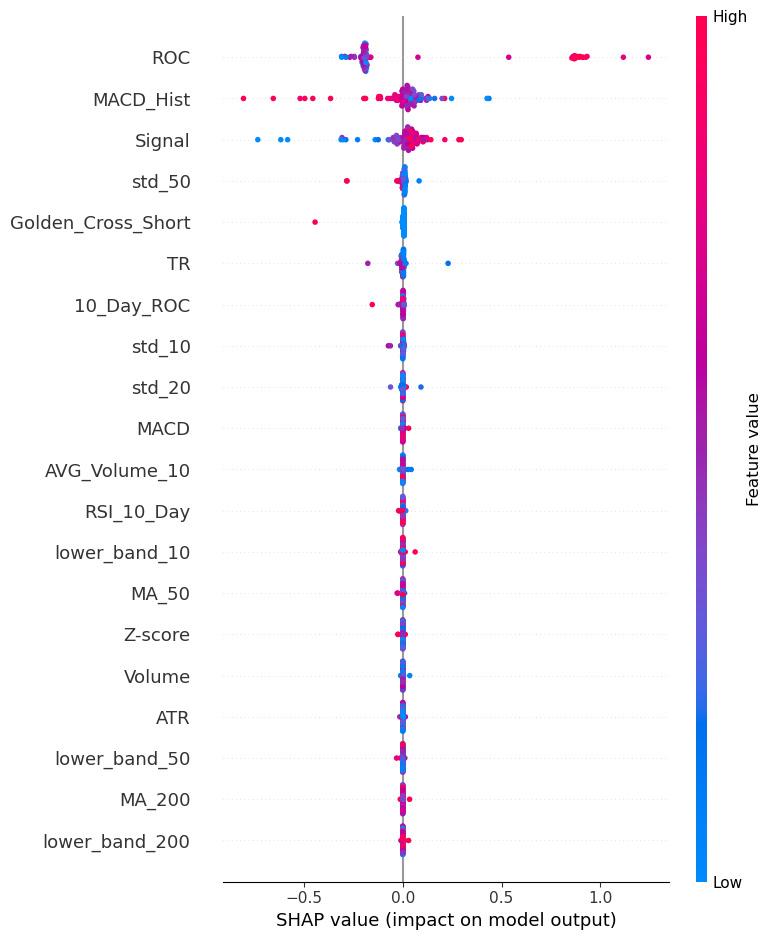

In [67]:
import shap

def model_predict(data):
    return model.predict(data)

# Use a small sample of the data to initialize the KernelExplainer
background = X.sample(n=100, random_state=42)

# Initialize the SHAP KernelExplainer with the custom prediction function
explainer = shap.KernelExplainer(model_predict, background)

# Calculate SHAP values for a sample of the data
sample_data = X.sample(n=100, random_state=42)
shap_values = explainer.shap_values(sample_data)

# Plot the SHAP summary plot
%matplotlib inline
shap.summary_plot(shap_values, sample_data)

In [59]:
def get_stock_data(symbol):
    stock_df = pd.read_csv('data/sp500_stocks.csv')
    stock = yf.Ticker(symbol)
    data = stock.history(period='1d', interval='1d')  


    if not data.empty:
        latest_data = data.iloc[-1]
        time = latest_data.name
        open_price = latest_data['Open']
        high = latest_data['High']
        low = latest_data['Low']
        close = latest_data['Close']
        volume = latest_data['Volume']
        new_row = pd.DataFrame({
            'Symbol': [symbol],
            'Date': [datetime.datetime.strftime(time, '%Y-%m-%d')],
            'Open': [open_price],
            'High': [high],
            'Low': [low],
            'Close': [close],
            'Volume': [volume]
        })
        stock_df = pd.concat([stock_df, new_row], ignore_index=True).fillna(0)
        return stock_df
    
stock = get_stock_data1('INTC')
stock

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,MMM,44.016720,69.414719,69.774246,69.122070,69.473244,3640265.0
1,2010-01-05,MMM,43.741032,68.979935,69.590302,68.311035,69.230766,3405012.0
2,2010-01-06,MMM,44.361340,69.958191,70.735786,69.824417,70.133781,6301126.0
3,2010-01-07,MMM,44.393162,70.008362,70.033447,68.662209,69.665550,5346240.0
4,2010-01-08,MMM,44.705990,70.501671,70.501671,69.648827,69.974915,4073337.0
...,...,...,...,...,...,...,...,...
1868641,2024-10-02,ZTS,192.460007,192.460007,194.389999,191.259995,193.520004,1233300.0
1868642,2024-10-03,ZTS,190.990005,190.990005,192.330002,190.000000,191.889999,1325000.0
1868643,2024-10-04,ZTS,190.029999,190.029999,191.869995,189.000000,190.990005,1697700.0
1868644,2024-10-07,ZTS,187.279999,187.279999,189.904205,186.639999,190.080002,1846234.0
